# Local approximation of a bivariate quadratic expression using linear regression using Keras

Given two features, extract y (the label), perform linear regression
Using the same model as in the main [bivariate linear regression notebook](LinearRegressionBivariate.ipynb)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas

In [2]:
usingTensorBoard = False

In 2D, it would require many points to uniformly cover the x plan

It is then prefer to draw x points from a 2D uniform distribution

Ploting y as function of $x_0, x_1$ is then more challenging as $x_0$ and $x_1$ are not continuous monotonic vectors

$f(x) = (x_0−0.2)^4 + (x_0−0.1)^3 + 0.1 x_1^2 + 0.35 = x_0^4 + 0.2 x_0^3 − 0.06 x_0^2 − 0.002 x_0 + 0.1 x_1^2 + 0.3506$

In [3]:
nFeatures = 2
# f(x) as a bivariate polynom
fPoly = np.array([[-0.002, 0], [-0.06, 0.1], [0.2, 0], [1, 0]])
# Generator
def generateBatch(N):
    #
    xMin = np.array([0, -0.5])
    xMax = np.array([0.5, 0.5])
    #
    b = 0.35
    std = 0.01
    #
    x = random.uniform(xMin, xMax, (N, nFeatures))
    yClean = (x[:,0]-0.2)**4 + (x[:,0]-0.1)**3 + 0.1*x[:,1]**2 + b
    y =  yClean + random.normal(0, std, N) 
    return (x, y, yClean)

In [4]:
N = 100000
xTrain, yTrain, yTrainClean = generateBatch(N);

xTest, yTest, yTestClean = generateBatch(N);

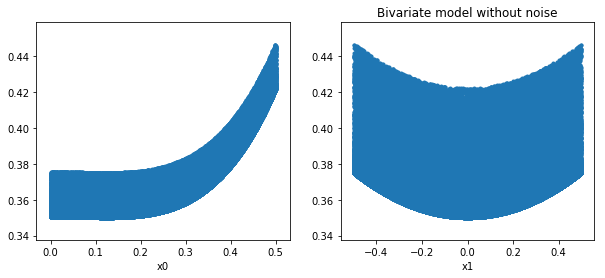

In [5]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(xTrain[:,0], yTrainClean, marker='.');
plt.xlabel('x0')
plt.subplot(1,2,2)
plt.scatter(xTrain[:,1], yTrainClean, marker='.');
plt.xlabel('x1')
plt.title('Bivariate model without noise');

It looks like a tobogan from the side ($x_0$) and from the front ($x_1$)

# Single neuron model with Keras

In [6]:
# Number of epochs
nEpoch = 8
nBatch = 128 # 32 is default

# Model
model1 = keras.models.Sequential([
  keras.layers.Dense(1, activation='linear', input_shape=[nFeatures])
])
model1.compile(optimizer='adam',
              loss=keras.losses.mean_squared_error, 
              metrics=['kullback_leibler_divergence'])

# Tensor board
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", 
                                     histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]

Using Kullback-Leibler divergence as an extra measure of the model.

References:
- https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
- (French) https://www.science-emergence.com/Articles/Divergence-de-Kullback-Leibler-avec-python-et-matplotlib/


$D_{KL}(P \Vert Q)=\int_{-\infty}^{+\infty} p(x) log\bigl(\frac{p(x)}{q(x)}\bigr)$

In [7]:
# Fit
hist1 = model1.fit(xTrain, yTrain, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

In [8]:
weights1, biases1 = model1.get_weights()
print('Est W =', weights1.reshape(-1), ', b =', biases1[0])

Est W = [ 0.10888916 -0.00077226] , b = 0.344824


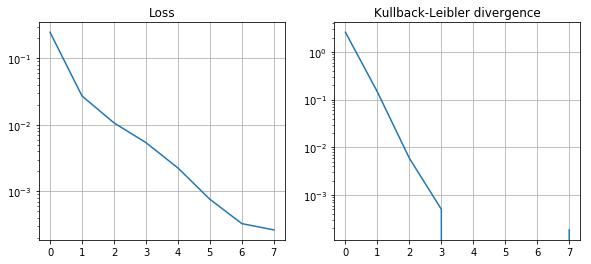

In [9]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.semilogy(hist1.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.semilogy(hist1.history['kullback_leibler_divergence'])
plt.grid()
plt.title('Kullback-Leibler divergence');

### Test model

In [10]:
yEst1 = np.matmul(xTest, weights1) + biases1

Gradient descent MSE = 2.582e-04


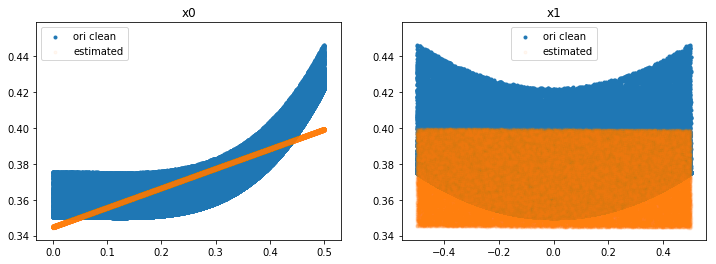

In [11]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.')
plt.scatter(xTest[:,0], yEst1, marker='.', alpha=0.05)
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.')
plt.scatter(xTest[:,1], yEst1, marker='.', alpha=0.05)
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse1 = metrics.mean_squared_error(yTest, yEst1)
print('Gradient descent MSE = {:.3e}'.format(mse1));

# Using a 2 layer Neural Network for a better fit

In [12]:
# Number of epochs
nEpoch = 50
nBatch = 256 # 32 is default

# Model
model2 = keras.models.Sequential([
    keras.layers.Dense(8, activation=keras.activations.softplus, input_shape=[nFeatures],      # <---
                        bias_regularizer=keras.regularizers.l1(0.00001),      # <---
                        activity_regularizer=keras.regularizers.l1(0.00001)), # <----
    keras.layers.Dense(1, activation='linear')
])
model2.compile(optimizer='adam',
              loss=keras.losses.mean_squared_error, 
              metrics=['kullback_leibler_divergence'])

# Tensor board
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", 
                                     histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]
    
# Fit
hist2 = model2.fit(xTrain, yTrain, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

In [13]:
model2.get_weights()

[array([[-6.49227476, -2.81793523, -3.06485772, -3.48774123, -5.13236618,
         -3.53966546, -5.03955936, -3.62101626],
        [-2.3812995 ,  0.08126453,  0.08307733,  0.0896488 ,  0.02016918,
         -1.46027088,  3.46687007,  0.08961134]], dtype=float32),
 array([-3.96435332, -3.40981531, -3.67733431, -3.83783007, -4.37687826,
        -4.29402161, -4.28260756, -3.88717628], dtype=float32),
 array([[ 0.75789756],
        [-1.29216444],
        [-1.04893863],
        [-0.88584119],
        [-0.09954754],
        [ 0.41112006],
        [ 0.84777051],
        [-0.82035601]], dtype=float32),
 array([ 0.41015902], dtype=float32)]

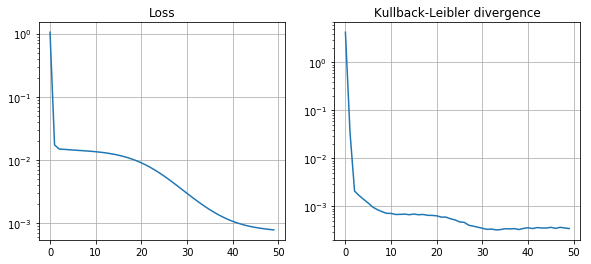

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.semilogy(hist2.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.semilogy(hist2.history['kullback_leibler_divergence'])
plt.grid()
plt.title('Kullback-Leibler divergence');

### Test model with two layers

In [15]:
yEst2 = model2.predict(xTest).reshape(-1)

Neural MSE = 2.627e-04


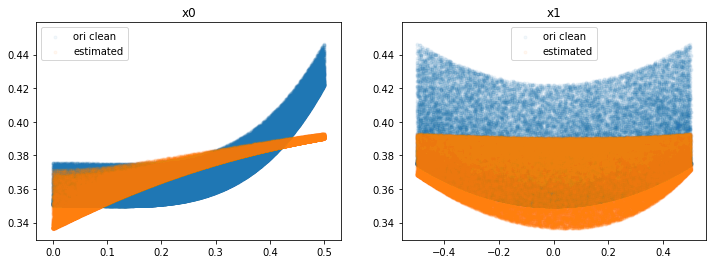

In [16]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.', alpha=0.05)
plt.scatter(xTest[:,0], yEst2, marker='.', alpha=0.05)
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.', alpha=0.05)
plt.scatter(xTest[:,1], yEst2, marker='.', alpha=0.05)
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse2 = metrics.mean_squared_error(yTest, yEst2)
print('Neural MSE = {:.3e}'.format(mse2));

### Conclusion on the two layer model

Adding a second layers leads to better fitting of the generation function (polynomial degree 4).

This is however mostly due to the non-linear activation function (Softplus), this is shown below with the same model but with a Relu activation. The predicted data is showing the elbows of the multiple Relu.

### Two layer model using Relu

In [17]:
# Number of epochs
nEpoch = 24
nBatch = 256 # 32 is default

# Model
model3 = keras.models.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=[nFeatures],      # <---
                        bias_regularizer=keras.regularizers.l1(0.00001),      
                        activity_regularizer=keras.regularizers.l1(0.00001)), 
    keras.layers.Dense(1, activation='linear')
])
model3.compile(optimizer='adam',
              loss=keras.losses.mean_squared_error, 
              metrics=['kullback_leibler_divergence'])

# Tensor board
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", 
                                     histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]
    
# Fit
hist3 = model3.fit(xTrain, yTrain, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

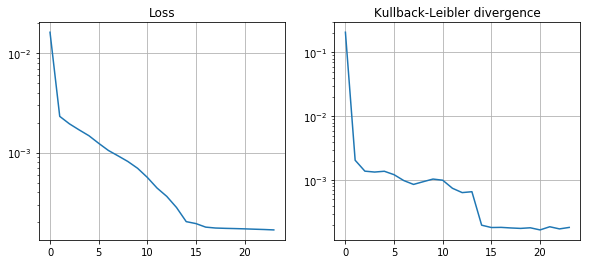

In [18]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.semilogy(hist3.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.semilogy(hist3.history['kullback_leibler_divergence'])
plt.grid()
plt.title('Kullback-Leibler divergence');

In [19]:
yEst3 = model3.predict(xTest).reshape(-1)

Neural MSE = 1.319e-04


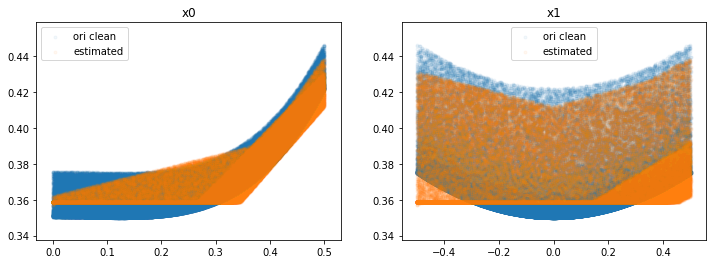

In [20]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(xTest[:,0], yTestClean, marker='.', alpha=0.05)
plt.scatter(xTest[:,0], yEst3, marker='.', alpha=0.05)
plt.title('x0')
plt.legend(('ori clean', 'estimated'))
plt.subplot(1,2,2)
plt.scatter(xTest[:,1], yTestClean, marker='.', alpha=0.05)
plt.scatter(xTest[:,1], yEst3, marker='.', alpha=0.05)
plt.title('x1')
plt.legend(('ori clean', 'estimated'))
mse3 = metrics.mean_squared_error(yTest, yEst3)
print('Neural MSE = {:.3e}'.format(mse3));

# Where to go from here ?

__Other two feature linear implementation__ [using "raw" Python](LinearRegressionBivariate.html) ([Notebook](LinearRegressionBivariate.ipynb))

__Compare with the two feature binary classification using logistic regression__ [using Keras](../classification/ClassificationContinuous2Features-Keras.html) ([Notebook](../classification/ClassificationContinuous2Features-Keras.ipynb]))